# Triton Sensors — Point Cloud ML Baselines (Example Notebook)

This notebook is a **sandbox** to help you go from a `replay_*.json` point-cloud file to:
- quick visualization
- basic preprocessing
- (optional) DBSCAN clustering on frames
- feature extraction (per-frame + temporal windows)
- a **baseline Random Forest** classifier (requires labels; includes a simple manual/pseudo-label workflow)

> Notes  
> - Your point cloud points may have **7 values**; this notebook uses the first 5 as: `x, y, z, velocity, intensity` (same assumption as the provided `radar_3d_visualizer.py`).  
> - The notebook also converts `y` into a more intuitive **height** coordinate using: `height = radar_height - y`.

---


In [1]:
JSON_PATH = "/Users/mohammedamin/Desktop/Projects/plextech/tritonsensors-plextech/example/sample_data/binData/11_09_2025_12_17_47/replay_1.json"   # <-- set me
RADAR_HEIGHT_M = 2.7                      # ceiling mount height used to convert y -> height

# Optional: if your file isn't found, we'll fall back to a tiny synthetic demo dataset


In [2]:
import json
import numpy as np
import pandas as pd

from pathlib import Path

# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Clustering (optional)
from sklearn.cluster import DBSCAN

# Visualization
import matplotlib.pyplot as plt


In [3]:
def load_replay(json_path: str):
    """Load a TI ODS-style replay JSON with top-level key: 'data' (list of frames)."""
    with open(json_path, "r") as f:
        obj = json.load(f)
    frames = obj.get("data", [])
    if not isinstance(frames, list):
        raise ValueError("Expected obj['data'] to be a list of frames.")
    return obj, frames

json_path = Path(JSON_PATH)
if json_path.exists():
    replay_obj, frames = load_replay(str(json_path))
    print(f"Loaded file: {json_path}")

print(f"Frames: {len(frames)}")
print("Top-level keys:", list(replay_obj.keys())[:10])


Loaded file: /Users/mohammedamin/Desktop/Projects/plextech/tritonsensors-plextech/example/sample_data/binData/11_09_2025_12_17_47/replay_1.json
Frames: 960
Top-level keys: ['cfg', 'demo', 'device', 'data']


In [4]:
def frame_to_df(frame, radar_height_m: float, use_first_n_cols: int = 5):
    """Convert one frame's pointCloud array to a DataFrame.

    Assumes columns: x, y, z, velocity, intensity in first 5 entries.
    Adds:
      - y_raw: original y
      - height: radar_height - y_raw
    """
    fd = frame.get("frameData", frame)  # tolerate either wrapping
    pc = np.asarray(fd.get("pointCloud", []), dtype=float)
    if pc.size == 0:
        return pd.DataFrame(columns=["x","y_raw","z","velocity","intensity","height"])
    if pc.ndim == 1:
        pc = pc.reshape(1, -1)

    n_cols = pc.shape[1]
    if n_cols < 3:
        raise ValueError(f"Point cloud has too few columns: {n_cols}")

    # Use first 5 columns if available (x,y,z,v,intensity)
    cols = ["x", "y_raw", "z", "velocity", "intensity"]
    use = min(use_first_n_cols, n_cols)
    base = pc[:, :use]
    df = pd.DataFrame(base, columns=cols[:use])

    # add extra columns (if any)
    for i in range(use, n_cols):
        df[f"extra_{i-use}"] = pc[:, i]

    if "y_raw" in df.columns:
        df["height"] = radar_height_m - df["y_raw"]
    else:
        df["height"] = np.nan
    return df

dfs = [frame_to_df(fr, RADAR_HEIGHT_M) for fr in frames]
sizes = [len(d) for d in dfs]
print(f"Points per frame (min/median/max): {np.min(sizes)} / {int(np.median(sizes))} / {np.max(sizes)}")
# No filtering for now: use raw frames
dfs_f = [d.copy().reset_index(drop=True) for d in dfs]



Points per frame (min/median/max): 13 / 76 / 151


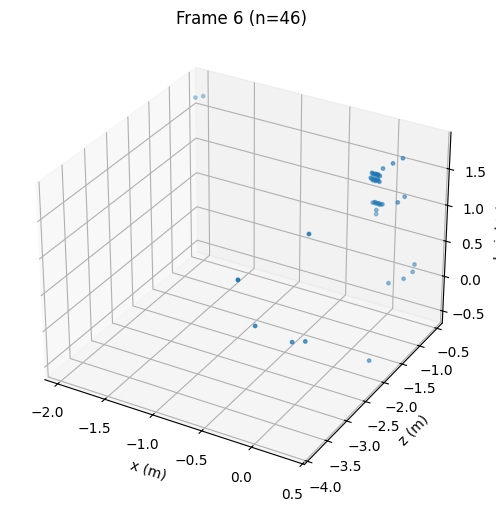

In [5]:
def plot_frame_3d(df, title="Frame"):
    if df.empty:
        print("Empty frame.")
        return
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(df["x"], df["z"], df["height"], s=6)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    ax.set_zlabel("height (m)")
    ax.set_title(title)
    plt.show()

frame_idx = 5
plot_frame_3d(dfs[frame_idx], title=f"Frame {frame_idx+1} (n={len(dfs[frame_idx])})")




DBSCAN parameters:
- `eps`: neighbor distance in meters
- `min_samples`: minimum points to form a dense region


Clusters: cluster
-1    25
 0    21
Name: count, dtype: int64


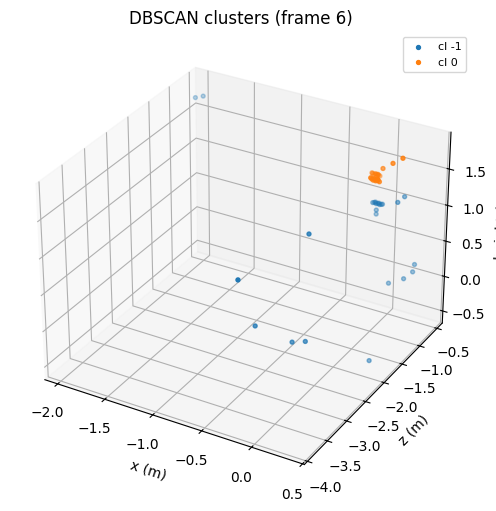

In [6]:
def dbscan_cluster_frame(df, eps=0.25, min_samples=10, use_cols=("x","z","height")):
    if df.empty:
        return df.copy(), np.array([], dtype=int)

    X = df.loc[:, list(use_cols)].to_numpy()
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)

    out = df.copy()
    out["cluster"] = labels
    return out, labels

dfc, labels = dbscan_cluster_frame(dfs_f[frame_idx], eps=0.25, min_samples=12)
print("Clusters:", pd.Series(dfc["cluster"]).value_counts().sort_index())

def plot_clusters_3d(df, title="Clusters"):
    if df.empty:
        print("Empty frame.")
        return
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection="3d")
    for cl, grp in df.groupby("cluster"):
        ax.scatter(grp["x"], grp["z"], grp["height"], s=8, label=f"cl {cl}")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    ax.set_zlabel("height (m)")
    ax.set_title(title)
    ax.legend(loc="upper right", fontsize=8)
    plt.show()

plot_clusters_3d(dfc, title=f"DBSCAN clusters (frame {frame_idx+1})")


In [7]:
def compute_frame_features(df):
    """Return a dict of summary stats for one frame."""
    if df.empty:
        return dict(
            n_points=0,
            x_mean=np.nan, z_mean=np.nan, h_mean=np.nan,
            x_std=np.nan, z_std=np.nan, h_std=np.nan,
            h_min=np.nan, h_max=np.nan, h_range=np.nan,
            v_mean=np.nan, v_abs_mean=np.nan, v_abs_max=np.nan,
            inten_mean=np.nan, inten_max=np.nan
        )

    feats = {}
    feats["n_points"] = len(df)

    feats["x_mean"] = df["x"].mean()
    feats["z_mean"] = df["z"].mean()
    feats["h_mean"] = df["height"].mean()

    feats["x_std"]  = df["x"].std(ddof=0)
    feats["z_std"]  = df["z"].std(ddof=0)
    feats["h_std"]  = df["height"].std(ddof=0)

    feats["h_min"] = df["height"].min()
    feats["h_max"] = df["height"].max()
    feats["h_range"] = feats["h_max"] - feats["h_min"]

    if "velocity" in df.columns:
        feats["v_mean"] = df["velocity"].mean()
        feats["v_abs_mean"] = df["velocity"].abs().mean()
        feats["v_abs_max"] = df["velocity"].abs().max()
    else:
        feats["v_mean"] = np.nan
        feats["v_abs_mean"] = np.nan
        feats["v_abs_max"] = np.nan

    if "intensity" in df.columns:
        feats["inten_mean"] = df["intensity"].mean()
        feats["inten_max"] = df["intensity"].max()
    else:
        feats["inten_mean"] = np.nan
        feats["inten_max"] = np.nan

    return feats

features = pd.DataFrame([compute_frame_features(d) for d in dfs_f])
features.insert(0, "frame_idx", np.arange(len(features)))
features.head()


,frame_idx,n_points,x_mean,z_mean,h_mean,x_std,z_std,h_std,h_min,h_max,h_range,v_mean,v_abs_mean,v_abs_max,inten_mean,inten_max
0,0,88,-0.138809,-1.501863,0.746215,0.113284,1.063270,0.475996,-0.028077,1.638350,1.666427,0.005170,0.124864,0.39452,31.226363,81.519998
1,1,76,-0.203630,-1.725560,0.933117,0.135600,1.479027,0.488219,-1.197113,1.610679,2.807792,0.076388,0.193517,0.53536,51.754209,165.239996
2,2,77,-0.177055,-1.134578,0.808756,0.113192,0.886927,0.461718,-0.093655,1.573768,1.667423,-0.142673,0.176382,0.59164,20.189090,31.999999
3,3,79,-0.027479,-1.228154,1.146093,0.189273,0.948388,0.454099,-1.362844,1.754584,3.117428,-0.024977,0.099882,0.45080,24.688101,46.879999
4,4,107,-0.075650,-0.627010,1.244324,0.171026,1.474152,0.497675,-0.045178,1.727439,1.772617,-0.149797,0.164541,0.28168,17.469158,30.639999


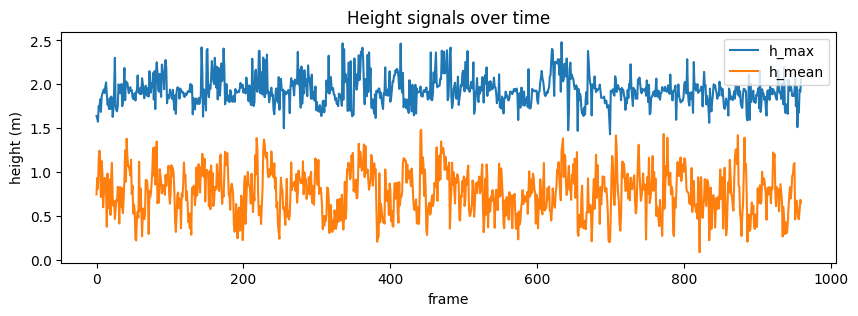

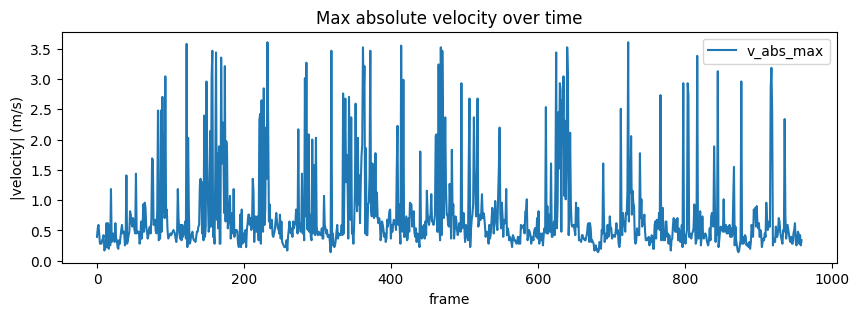

In [8]:
plt.figure(figsize=(10,3))
plt.plot(features["frame_idx"], features["h_max"], label="h_max")
plt.plot(features["frame_idx"], features["h_mean"], label="h_mean")
plt.xlabel("frame")
plt.ylabel("height (m)")
plt.title("Height signals over time")
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(features["frame_idx"], features["v_abs_max"], label="v_abs_max")
plt.xlabel("frame")
plt.ylabel("|velocity| (m/s)")
plt.title("Max absolute velocity over time")
plt.legend()
plt.show()



## 8) Temporal window features

Falls/unsafe pose are **temporal** events. A simple way to incorporate time:
- rolling windows over frame-level features (mean, min, max, delta)

Set `WINDOW = 8` if you have ~8 FPS and want ~1 second context.


In [9]:
WINDOW = 8  # frames

def add_window_features(df, window=8):
    out = df.copy()

    out["h_max_delta"] = out["h_max"].diff()

    roll = out.rolling(window=window, min_periods=1)
    out["h_max_min_w"] = roll["h_max"].min()
    out["h_max_max_w"] = roll["h_max"].max()
    out["h_mean_min_w"] = roll["h_mean"].min()
    out["h_mean_max_w"] = roll["h_mean"].max()

    out["v_abs_max_max_w"] = roll["v_abs_max"].max()
    out["v_abs_mean_mean_w"] = roll["v_abs_mean"].mean()

    LOW_H_MAX = 0.7 
    out["low_height_frac_w"] = roll["h_max"].apply(lambda s: np.mean(s < LOW_H_MAX), raw=False)

    return out

features_w = add_window_features(features, window=WINDOW)
features_w.head(12)


,frame_idx,n_points,x_mean,z_mean,h_mean,x_std,z_std,h_std,h_min,h_max,...,inten_mean,inten_max,h_max_delta,h_max_min_w,h_max_max_w,h_mean_min_w,h_mean_max_w,v_abs_max_max_w,v_abs_mean_mean_w,low_height_frac_w
0,0,88,-0.138809,-1.501863,0.746215,0.113284,1.063270,0.475996,-0.028077,1.638350,...,31.226363,81.519998,NaN,1.638350,1.638350,0.746215,0.746215,0.39452,0.124864,0.0
1,1,76,-0.203630,-1.725560,0.933117,0.135600,1.479027,0.488219,-1.197113,1.610679,...,51.754209,165.239996,-0.027671,1.610679,1.638350,0.746215,0.933117,0.53536,0.159190,0.0
2,2,77,-0.177055,-1.134578,0.808756,0.113192,0.886927,0.461718,-0.093655,1.573768,...,20.189090,31.999999,-0.036912,1.573768,1.638350,0.746215,0.933117,0.59164,0.164921,0.0
3,3,79,-0.027479,-1.228154,1.146093,0.189273,0.948388,0.454099,-1.362844,1.754584,...,24.688101,46.879999,0.180816,1.573768,1.754584,0.746215,1.146093,0.59164,0.148661,0.0
4,4,107,-0.075650,-0.627010,1.244324,0.171026,1.474152,0.497675,-0.045178,1.727439,...,17.469158,30.639999,-0.027145,1.573768,1.754584,0.746215,1.244324,0.59164,0.151837,0.0
5,5,46,-0.053142,-1.141230,1.139393,0.422763,0.728569,0.547444,-0.504339,1.828592,...,11.644348,16.520000,0.101153,1.573768,1.828592,0.746215,1.244324,0.59164,0.153476,0.0
6,6,49,0.173767,-1.102498,0.715947,0.148004,0.676964,0.631881,-0.754887,1.685551,...,14.981224,23.759999,-0.143041,1.573768,1.828592,0.715947,1.244324,0.59164,0.146501,0.0
7,7,77,0.288050,-0.861437,1.125372,0.137828,0.414076,0.735519,-1.283650,1.859509,...,15.844675,21.640000,0.173958,1.573768,1.859509,0.715947,1.244324,0.59164,0.155399,0.0
8,8,103,0.233366,-0.275601,1.003891,0.340450,0.977969,0.726707,-0.732072,1.895399,...,17.287767,30.879999,0.035890,1.573768,1.895399,0.715947,1.244324,0.59164,0.163348,0.0
9,9,62,0.195989,-0.074244,0.599302,0.468145,1.116349,0.697963,-0.173813,1.919185,...,14.294838,26.879999,0.023787,1.573768,1.919185,0.599302,1.244324,0.59164,0.152221,0.0


In [10]:
# (start_frame_inclusive, end_frame_inclusive, pose_label)
manual_pose_ranges = [
    # (100, 140, "walking"),
    # (141, 180, "standing_or_idle"),
    # (181, 220, "crouch_or_sit"),
]

DEFAULT_POSE = "standing_or_idle"
pose_labels = np.array([DEFAULT_POSE] * len(features_w), dtype=object)
manual_mask = np.zeros(len(features_w), dtype=bool)

for a, b, label in manual_pose_ranges:
    pose_labels[a:b+1] = label
    manual_mask[a:b+1] = True

print("Manual-labeled frames:", int(manual_mask.sum()))
print("Pose counts (manual defaults included):")
print(pd.Series(pose_labels).value_counts().to_dict())


Manual-labeled frames: 0
Pose counts (manual defaults included):
{'standing_or_idle': 960}


In [11]:

USE_PSEUDO_POSE = (len(manual_pose_ranges) == 0)
KNOWN_NO_FLOOR = True
ALLOWED_POSES = ["walking", "standing_or_idle"]  # keep simple for this video

if USE_PSEUDO_POSE:
    pseudo_pose = np.array(["standing_or_idle"] * len(features_w), dtype=object)

    v_abs_mean = features_w["v_abs_mean"].to_numpy()
    valid_v = np.isfinite(v_abs_mean)

    if valid_v.any():
        # Lower quantile -> more sensitive to "walking" when two people are active.
        WALK_Q = 0.55
        walk_thresh = np.nanquantile(v_abs_mean[valid_v], WALK_Q)
        pseudo_pose[v_abs_mean >= walk_thresh] = "walking"

    if KNOWN_NO_FLOOR:
        # Explicitly prevent floor class in this sample.
        pseudo_pose[pseudo_pose == "lying_or_floor"] = "standing_or_idle"

    # Optional cleanup: if a class is too tiny, fold it into standing.
    counts = pd.Series(pseudo_pose).value_counts()
    for cls, cnt in counts.items():
        if cls not in ALLOWED_POSES and cnt < 30:
            pseudo_pose[pseudo_pose == cls] = "standing_or_idle"

    # Hard cap to allowed classes for this recording.
    pseudo_pose = np.where(np.isin(pseudo_pose, ALLOWED_POSES), pseudo_pose, "standing_or_idle")
    pose_labels = pseudo_pose

print("Pose labels used:")
print(pd.Series(pose_labels).value_counts().to_dict())


Pose labels used:
{'standing_or_idle': 528, 'walking': 432}


In [12]:
X = features_w.drop(columns=["frame_idx"]).copy()
X = X.fillna(X.median(numeric_only=True))
y = pd.Series(pose_labels, name="pose")

print("Class distribution:")
print(y.value_counts())
print("\nNote: if these are pseudo labels, metrics only show pipeline consistency.")

if y.nunique() < 2:
    print("Need at least 2 classes to train. Add manual_pose_ranges or adjust pseudo labeling.")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    clf = RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced_subsample"
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    labels_sorted = sorted(y.unique())
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred, labels=labels_sorted))
    print("Label order:", labels_sorted)
    print()
    print(classification_report(y_test, y_pred, digits=3, zero_division=0))

    # Predict all frames for timeline visualization
    features_w["pose_pred"] = clf.predict(X)


Class distribution:
pose
standing_or_idle    528
walking             432
Name: count, dtype: int64

Note: if these are pseudo labels, metrics only show pipeline consistency.


Confusion matrix:
[[132   0]
 [  0 108]]
Label order: ['standing_or_idle', 'walking']

                  precision    recall  f1-score   support

standing_or_idle      1.000     1.000     1.000       132
         walking      1.000     1.000     1.000       108

        accuracy                          1.000       240
       macro avg      1.000     1.000     1.000       240
    weighted avg      1.000     1.000     1.000       240



## 11) Pose timeline + feature importance


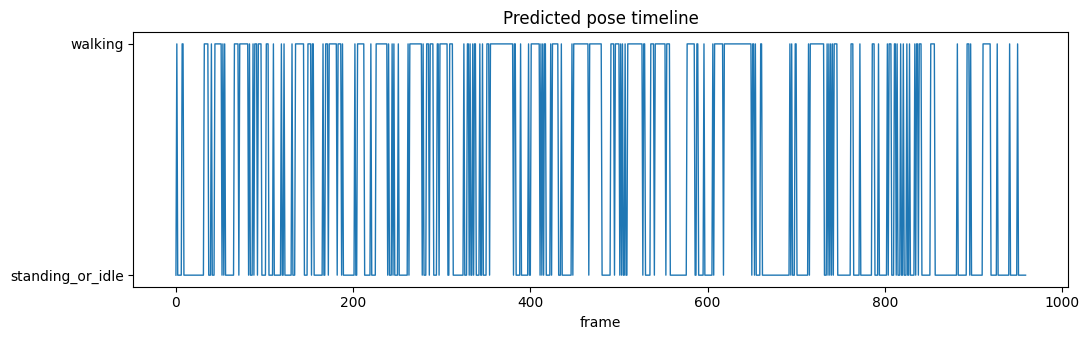

v_abs_mean           0.522199
v_abs_max            0.096897
v_mean               0.085152
v_abs_mean_mean_w    0.082761
z_std                0.025738
h_mean_min_w         0.018153
z_mean               0.016733
x_std                0.016171
v_abs_max_max_w      0.015527
h_mean               0.013895
h_max                0.013460
n_points             0.010823
h_max_max_w          0.010796
h_std                0.010500
h_max_min_w          0.009826
x_mean               0.009188
h_mean_max_w         0.008662
inten_mean           0.007285
h_max_delta          0.007258
h_min                0.007070
dtype: float64

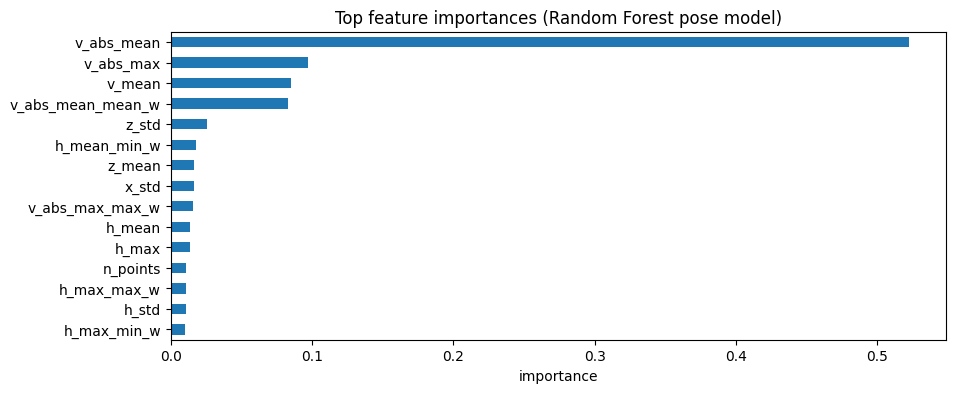

In [13]:
if "clf" not in globals():
    print("Model not trained; skip timeline and feature importance.")
else:
    pose_series = features_w["pose_pred"] if "pose_pred" in features_w.columns else pd.Series(pose_labels)
    pose_order = ["lying_or_floor", "crouch_or_sit", "standing_or_idle", "walking"]
    pose_order = [p for p in pose_order if p in set(pose_series)]
    pose_to_y = {p: i for i, p in enumerate(pose_order)}

    plt.figure(figsize=(11, 3.5))
    plt.plot(features_w["frame_idx"], pose_series.map(pose_to_y), lw=1)
    plt.yticks(range(len(pose_order)), pose_order)
    plt.xlabel("frame")
    plt.title("Predicted pose timeline")
    plt.tight_layout()
    plt.show()

    importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    display(importances.head(20))

    plt.figure(figsize=(10,4))
    importances.head(15).iloc[::-1].plot(kind="barh")
    plt.title("Top feature importances (Random Forest pose model)")
    plt.xlabel("importance")
    plt.show()
